# Shopee Product Classification: Baseline CNN Model and improvements

In this notebook, we will develop a model which can predict a product image's Shopee product category. 

The models are implemented in PyTorch. This notebook was run on a M1 Macbook Pro, with dependency versions as documented in environment.yml

The data used in this notebook can be downloaded [here](https://drive.google.com/file/d/1RYb41Mv_mrc_OJFIGvVT_6aTwVV_xngu/view?usp=sharing). Download the data and unzip it to the `data` folder of this project or run the code in the cell below.


In [ ]:
!wget --load-cookies cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate https://drive.google.com/uc?export=download&id=1RYb41Mv_mrc_OJFIGvVT_6aTwVV_xngu -O | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1RYb41Mv_mrc_OJFIGvVT_6aTwVV_xngu" -O selected-images.tar.gz && rm -rf cookies.txt

!tar -xvf selected-images.tar.gz --directory ../data/
# Use the following instead if running this notebook from the root
# !tar -xvf selected-images.tar.gz --directory data/
!rm selected-images.tar.gz

## Data Setup

In [1]:
# If notebook is not at the root
# This is needed for this notebook to be runnable from the `notebooks` folder instead of the root.
import sys
sys.path.insert(0, '../')
image_dir = '../data/selected_images/'

In [ ]:
# If notebook is at the root, uncomment and run this instead
# image_dir = 'data/selected_images/'

In [2]:
from model import dataset

data = dataset.DataSet(max_num_img=500, crop=0.9, path=image_dir)
data.load_all()

# For all models, we will train with a batch size of 32
batch_size = 32
seed = 42
data_seed = 42

100%|██████████| 500/500 [00:01<00:00, 257.00it/s]


## Baseline Model
Since this is an image classification problem, we build a baseline model which uses a few stacked 3x3 convolutions for feature extraction. We have a final fully connected layer which takes in the final output from the convolutional layers and outputs a list of probabilities for each class. The exact structure is as follows: Conv3-16 -> Conv16-16 -> 2x2 maxPool -> Conv16-32 -> Conv32-32 -> 2x2 maxPool -> Conv32-64 -> Conv64-64 -> 2x2 maxPool -> Conv64-128 -> Conv128-128 -> 2x2 maxPool -> 1x1 adaptive average pool -> 128-[num classes] fc; where ConvA-B means the number of input channels is A, and the number of output channels is B. We apply ReLU then batch normalisation after each 3x3 convolution. 

We found in our experiments that applying batch normalisation after each convolution results in better performance. In addition, we found that placing ReLU before batch normalisation results in better performance than batch normalisation before ReLU. 

In [4]:
import torch
import torch.nn as nn

from model import trainer, baseline_cnn_1

torch.manual_seed(seed)

baseline_cnn_model = baseline_cnn_1.BaselineCNN1(len(data.categories))
# Using regularisation
optimizer = torch.optim.Adam(baseline_cnn_model.parameters(), lr=4e-4, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# The trainer has methods to split the dataset into training (0.7), validation (0.1) and test (0.2) sets respectively.
# The seed is set accordingly for a consistent split.
mtrainer = trainer.Trainer(baseline_cnn_model, optimizer, criterion, data, batch_size, seed=data_seed, random_transform=False)

In [5]:
# Train the model for 30 epochs
# The trainer stores the model with the best validation set performance after 30 epochs. For all the models, we will compare the performance of the model with the best validation performance on the test set
mtrainer.run_train(30)

[Epoch   0]: Training loss: 1.752771 | Accuracy: 0.378730
[Epoch   0]: Validation loss: 1.782797 | Accuracy: 0.344444 | Within 3: 0.733333
[Epoch   1]: Training loss: 1.571027 | Accuracy: 0.445079
[Epoch   1]: Validation loss: 1.788241 | Accuracy: 0.362222 | Within 3: 0.711111
[Epoch   2]: Training loss: 1.461987 | Accuracy: 0.500952
[Epoch   2]: Validation loss: 1.546405 | Accuracy: 0.482222 | Within 3: 0.766667
[Epoch   3]: Training loss: 1.398670 | Accuracy: 0.522540
[Epoch   3]: Validation loss: 2.105829 | Accuracy: 0.353333 | Within 3: 0.628889
[Epoch   4]: Training loss: 1.333582 | Accuracy: 0.550159
[Epoch   4]: Validation loss: 1.388717 | Accuracy: 0.508889 | Within 3: 0.826667
[Epoch   5]: Training loss: 1.273665 | Accuracy: 0.574286
[Epoch   5]: Validation loss: 1.526939 | Accuracy: 0.484444 | Within 3: 0.831111
[Epoch   6]: Training loss: 1.218312 | Accuracy: 0.602222
[Epoch   6]: Validation loss: 1.427212 | Accuracy: 0.495556 | Within 3: 0.800000
[Epoch   7]: Training loss:

In [6]:
_, test_acc, _ = mtrainer.run_test(mtrainer.testloader, 3)
print(f'Accuracy of the best model on the test images: {test_acc*100} %') # Best model within 30 epochs

_, test_acc, _ = mtrainer.run_test(mtrainer.testloader, model=mtrainer.model)
print(f'Accuracy of the fully trained model on the test images: {test_acc*100} %') # Model after 30 epochs

Accuracy of the best model on the test images: 69.22222222222221 %
Accuracy of the fully trained model on the test images: 66.55555555555556 %


We found that the model tends to start overfitting the data rather quickly as the training accuracy goes beyond 90% after less than 20 epochs. Hence, we think that the generalisation of the model can be improved by reducing the extent of overfitting. We try a combination of adding regularisation to the model's weights and data augmentation by randomly transforming some of the images before training.

The following are the random transformations performed:
* Random Horizontal Flip (We do not perform vertical flips as in general no one would upload an upside down picture of their product)
* Random rotation within 10 degrees

The experiments were run with a learning rate of 0.0004. The average results of 5 rounds of running experiments with a combination of regularisation and data augmentation are as follows:

| Regularisation | With Random Augmentation | Accuracy|
|----------------|--------------------------|---------|
| 0 | No | 66.511 $\pm$ 2.584 % |
| 0.0001 | No | 65.978 $\pm$ 2.532 % |
| 0.0005 | No | 66.244 $\pm$ 1.972 % |
| 0.001 | No | 66.489 $\pm$ 2.877 % |
| 0.01 | No | 63.329 $\pm$ 1.501 % |
| 0 | Yes | 65.933 $\pm$ 1.092 % |
| 0.001 | Yes | 66.467 $\pm$ 0.614 % |

We observe that regularisation (with the Adam optimizer) unfortunately is not very effective at reducing the degree of overfitting in our case. Random data augmentation is effective but it also requires the model to be trained for more cycles, hence the performance of the model when trained with random data augmentation is not better than that without when trained for only 30 epochs. Howver, the performance improves noticably when trained for 10 more epochs.

Accuracy after training model for 40 epochs with random data augmentation:

| Regularisation | With Random Augmentation | Accuracy|
|----------------|--------------------------|---------|
| 0 | Yes | 67.178 $\pm$ 1.308 % |
| 0.001 | Yes | 67.844 $\pm$ 1.025 % |

## Improving the baseline model
The main challenge of our problem is the extraction of relevant features from pictures that could contain multiple objects. Hence improving the ability of the network to extract features from images by adding more convolution layers should result in better performance.

We define a ConvBlock[A][B] group as a set of 3x3 ConvA-B->ConvB-B convolution blocks.
We try improving the baseline model either by adding an additional ConvBlock[128][256] group, or stacking additional 3x3 convolution blocks with the same number of input and output channels. The former increases the number of features extracted and is roughly corresponds to increasing the ability of the network to extract higher level features while the latter is roughly equivalent to increasing the receptive field of the convolution group.

We found that adding the additional ConvBlock[128][256] group improves the performance of the model significantly. However stacking additional 3x3 convolution blocks with the same number of channels does not improve the performance of the model. The table below shows the results for the tow models over 5 runs with different random seeds. The experiments were run without regularisation and pre-training data augmentation for comparison against the baseline model in its baseline setting.

| Model | Learning Rate | Accuracy|
|-------|---------------|----------|
| `DeeperCNN`: additional Conv128-256->Conv256-256| 0.0004 | 69.600 $\pm$ 1.366 % |
| `DeeperCNN`: additional Conv128-256->Conv256-256| 0.0003 | 70.000 $\pm$ 1.969 %|
| `DeeperCNNWide` additional Conv128-128->Conv128-128| 0.0004 | 66.044 $\pm$ 1.580 %|
| `DeeperCNNWide`: additional Conv128-128->Conv128-128| 0.0003 | 66.666 $\pm$ 0.700 %|

We also tried increasing the depth of the classification layer, but found that it does not improve the performance of the model. This is because the main factor in the performance of the model is how well it is able to extract features from the given image. The classification layer merely weighs the features extracted to determine the most likely category. A single fully connected layer is sufficient in our case.

#### Model with an additional ConvBlock: `DeeperCNN`
This means adding an additional Conv128-256 -> Conv256-256 -> 2x2 maxPool to the model's feature extractor.

In [8]:
import torch
import torch.nn as nn

from model import trainer, deeper_cnn

torch.manual_seed(seed)

deeper_model = deeper_cnn.DeeperCNN(len(data.categories))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deeper_model.parameters(), lr=3e-4, weight_decay=6e-4)

mtrainer = trainer.Trainer(deeper_model, optimizer, criterion, data, batch_size, seed=data_seed, random_transform=False)

In [9]:
mtrainer.run_train(30)

[Epoch   0]: Training loss: 1.667367 | Accuracy: 0.421587
[Epoch   0]: Validation loss: 1.614436 | Accuracy: 0.446667 | Within 3: 0.766667
[Epoch   1]: Training loss: 1.461889 | Accuracy: 0.487302
[Epoch   1]: Validation loss: 1.486385 | Accuracy: 0.508889 | Within 3: 0.802222
[Epoch   2]: Training loss: 1.340605 | Accuracy: 0.533968
[Epoch   2]: Validation loss: 1.577937 | Accuracy: 0.453333 | Within 3: 0.773333
[Epoch   3]: Training loss: 1.206739 | Accuracy: 0.593651
[Epoch   3]: Validation loss: 1.409491 | Accuracy: 0.548889 | Within 3: 0.822222
[Epoch   4]: Training loss: 1.131779 | Accuracy: 0.610476
[Epoch   4]: Validation loss: 1.716549 | Accuracy: 0.424444 | Within 3: 0.773333
[Epoch   5]: Training loss: 1.015895 | Accuracy: 0.646349
[Epoch   5]: Validation loss: 1.409048 | Accuracy: 0.511111 | Within 3: 0.817778
[Epoch   6]: Training loss: 0.982448 | Accuracy: 0.675873
[Epoch   6]: Validation loss: 1.396926 | Accuracy: 0.591111 | Within 3: 0.860000
[Epoch   7]: Training loss:

In [10]:
_, test_acc, _ = mtrainer.run_test(mtrainer.testloader, 3)
print(f'Accuracy of the best model on the test images: {test_acc*100} %') # Best model within 30 epochs

_, test_acc, _ = mtrainer.run_test(mtrainer.testloader, model=mtrainer.model)
print(f'Accuracy of the fully trained model on the test images: {test_acc*100} %') # Model after 30 epochs

Accuracy of the best model on the test images: 71.44444444444444 %
Accuracy of the fully trained model on the test images: 71.44444444444444 %


### Model with additional 3x3 convolutional block: `DeeperCNNWide`
This means adding an additional Conv128-128 -> Conv128-128 to the model's feature extractor.

In [13]:
import torch
import torch.nn as nn

from model import trainer, deeper_cnn

torch.manual_seed(seed)

wider_model = deeper_cnn.DeeperCNNWide(len(data.categories))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(wider_model.parameters(), lr=3e-4, weight_decay=6e-4)

mtrainer = trainer.Trainer(wider_model, optimizer, criterion, data, batch_size, seed=data_seed, random_transform=False)

In [14]:
mtrainer.run_train(30)

[Epoch   0]: Training loss: 1.739391 | Accuracy: 0.378730
[Epoch   0]: Validation loss: 1.799310 | Accuracy: 0.395556 | Within 3: 0.728889
[Epoch   1]: Training loss: 1.504797 | Accuracy: 0.489524
[Epoch   1]: Validation loss: 1.906998 | Accuracy: 0.331111 | Within 3: 0.711111
[Epoch   2]: Training loss: 1.408505 | Accuracy: 0.531429
[Epoch   2]: Validation loss: 1.442103 | Accuracy: 0.526667 | Within 3: 0.817778
[Epoch   3]: Training loss: 1.310832 | Accuracy: 0.565397
[Epoch   3]: Validation loss: 1.477130 | Accuracy: 0.511111 | Within 3: 0.804444
[Epoch   4]: Training loss: 1.254593 | Accuracy: 0.568571
[Epoch   4]: Validation loss: 2.062638 | Accuracy: 0.317778 | Within 3: 0.706667
[Epoch   5]: Training loss: 1.179686 | Accuracy: 0.597143
[Epoch   5]: Validation loss: 1.382448 | Accuracy: 0.562222 | Within 3: 0.833333
[Epoch   6]: Training loss: 1.138971 | Accuracy: 0.617460
[Epoch   6]: Validation loss: 1.442669 | Accuracy: 0.482222 | Within 3: 0.800000
[Epoch   7]: Training loss:

In [15]:
_, test_acc, _ = mtrainer.run_test(mtrainer.testloader, 3)
print(f'Accuracy of the best model on the test images: {test_acc*100} %') # Best model within 30 epochs

_, test_acc, _ = mtrainer.run_test(mtrainer.testloader, model=mtrainer.model)
print(f'Accuracy of the fully trained model on the test images: {test_acc*100} %') # Model after 30 epochs

Accuracy of the best model on the test images: 65.33333333333333 %
Accuracy of the fully trained model on the test images: 67.33333333333333 %


## Exploring Residual networks

We explore networks with skip connections that would better allow information captured by earlier convolution blocks to better propagate to later layers in the network.

The `ResidualCNN` model, which is similar to `DeeperCNNWide` but has a skip connection for every 2 convolutional layers, was able to achieve slightly higher accuracy than the baseline model and `DeeperCNNWide` model, which suggests that skip connections can potentially improve performance in our case. `DeeperResidualCNN` has additional Conv128-256 and Conv256-256 blocks with skip connections and achieved comparable performance to the `DeeperCNN` model, which suggests that increasing the number of features extracted is a stronger contributing factor to performance improvement. The skip connections are not a very strong factor as our networks are not very deep.

The results for 5 runs with different seeds are as follows:

| Model | Learning Rate | Accuracy|
|-------|---------------|---------|
| ResidualCNN | 0.0004 | 68.044 $\pm$ 1.228 % |
| ResidualCNN | 0.0003 | 66.244 $\pm$ 1.308 %|
| DeeperResidualCNN | 0.0004 | 69.711 $\pm$ 1.770 % |
| DeeperResidualCNN | 0.0003 | 70.244 $\pm$ 0.806 % |

### ResidualCNN

In [27]:
import torch
import torch.nn as nn

from model import residual_cnn, trainer

torch.manual_seed(seed)
res_model = residual_cnn.ResidualCNN(len(data.categories))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(res_model.parameters(), lr=4e-4, weight_decay=5e-4)

mtrainer = trainer.Trainer(res_model, optimizer, criterion, data, batch_size, seed=data_seed, random_transform=False)

In [28]:
mtrainer.run_train(30)

[Epoch   0]: Training loss: 1.749519 | Accuracy: 0.388571
[Epoch   0]: Validation loss: 1.723505 | Accuracy: 0.382222 | Within 3: 0.733333
[Epoch   1]: Training loss: 1.547193 | Accuracy: 0.472063
[Epoch   1]: Validation loss: 2.822829 | Accuracy: 0.213333 | Within 3: 0.531111
[Epoch   2]: Training loss: 1.416754 | Accuracy: 0.512063
[Epoch   2]: Validation loss: 1.699172 | Accuracy: 0.446667 | Within 3: 0.711111
[Epoch   3]: Training loss: 1.336497 | Accuracy: 0.553968
[Epoch   3]: Validation loss: 1.609811 | Accuracy: 0.471111 | Within 3: 0.777778
[Epoch   4]: Training loss: 1.258435 | Accuracy: 0.570159
[Epoch   4]: Validation loss: 1.742243 | Accuracy: 0.433333 | Within 3: 0.720000
[Epoch   5]: Training loss: 1.184527 | Accuracy: 0.600635
[Epoch   5]: Validation loss: 2.485062 | Accuracy: 0.315556 | Within 3: 0.693333
[Epoch   6]: Training loss: 1.115207 | Accuracy: 0.630159
[Epoch   6]: Validation loss: 1.368038 | Accuracy: 0.508889 | Within 3: 0.846667
[Epoch   7]: Training loss:

In [29]:
test_loss, test_acc, top_k = mtrainer.run_test(mtrainer.testloader)
print(f'Accuracy of the best model on the test images: {test_acc*100} %')
test_loss, test_acc, top_k = mtrainer.run_test(mtrainer.testloader, model=mtrainer.model)
print(f'Accuracy of the fully trained model on the test images: {test_acc*100} %')

Accuracy of the best model on the test images: 67.88888888888889 %
Accuracy of the fully trained model on the test images: 67.88888888888889 %


### DeeperResidualCNN
This model is an add-on of `ResidualCNN` and has an additional ConvBlock[128][256]->ConvBlock[256][256] with skip connections. It's performance is comparable to `DeeperCNN` but seems to have a greater tendency to overfit.

In [16]:
from model import residual_cnn, trainer

torch.manual_seed(seed)
deeper_res = residual_cnn.DeeperResidualCNN(len(data.categories))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(deeper_res.parameters(), lr=3e-4, weight_decay=1e-4)

mtrainer = trainer.Trainer(deeper_res, optimizer, criterion, data, batch_size, seed=data_seed, random_transform=False)

In [17]:
mtrainer.run_train(30)

[Epoch   0]: Training loss: 1.717882 | Accuracy: 0.406984
[Epoch   0]: Validation loss: 1.693706 | Accuracy: 0.417778 | Within 3: 0.711111
[Epoch   1]: Training loss: 1.413866 | Accuracy: 0.509841
[Epoch   1]: Validation loss: 1.578994 | Accuracy: 0.455556 | Within 3: 0.768889
[Epoch   2]: Training loss: 1.287780 | Accuracy: 0.557460
[Epoch   2]: Validation loss: 1.926161 | Accuracy: 0.391111 | Within 3: 0.675556
[Epoch   3]: Training loss: 1.168129 | Accuracy: 0.599365
[Epoch   3]: Validation loss: 1.679911 | Accuracy: 0.453333 | Within 3: 0.802222
[Epoch   4]: Training loss: 1.053339 | Accuracy: 0.641905
[Epoch   4]: Validation loss: 1.266834 | Accuracy: 0.595556 | Within 3: 0.866667
[Epoch   5]: Training loss: 0.941556 | Accuracy: 0.675556
[Epoch   5]: Validation loss: 1.326450 | Accuracy: 0.577778 | Within 3: 0.848889
[Epoch   6]: Training loss: 0.866483 | Accuracy: 0.708571
[Epoch   6]: Validation loss: 2.058296 | Accuracy: 0.420000 | Within 3: 0.748889
[Epoch   7]: Training loss:

In [18]:
test_loss, test_acc, top_k = mtrainer.run_test(mtrainer.testloader)
print(f'Accuracy of the best model on the test images: {test_acc*100} %')
test_loss, test_acc, top_k = mtrainer.run_test(mtrainer.testloader, model=mtrainer.model)
print(f'Accuracy of the fully trained model on the test images: {test_acc*100} %')

Accuracy of the best model on the test images: 70.33333333333334 %
Accuracy of the fully trained model on the test images: 69.88888888888889 %


## Conclusion
`DeeperCNN` and `DeeperResidualCNN` are the best performing models. Our results suggest that increasing the number of features extracted is the greatest factor in performance improvement in our case.

## Other Possible Improvements
### Transfer Learning with Pretrained Model
One challenge we have is the diversity of images for each category. Hence the performance of the model can be improved if we swap out the feature block with the feature block of a model pre-trained on ImageNet. This model should already be able to recognise the objects in most of the images, what's left is then to learn the mapping of the features extracted from the images to the final category classification.

### Incorporate instance segmentation techniques
The challenge with shopee product images is they often come with addional text and brand labels, and might also contain multiple objects. One way to overcome this is to train an instance segmentation model to identify object boundaries in the images, and run the classifier on the object boundaries instead of the whole image. However this is very labour intensive for the data precessing required, as we would need to create object masks for the training data.

## Appendix
### Getting a sense of what confounds the model
The code below can be used to show the images that are misclassified by the model, which we can use to get a sense of how the model can be improved, or whether the data requires further cleaning.

In [8]:
import torch
import torch.nn as nn

from model import trainer, baseline_cnn_1

torch.manual_seed(seed)
# Set up and train model. Run the next cell directly if the model and its trainer is already in memory
baseline_cnn_model = baseline_cnn_1.BaselineCNN1(len(data.categories))
optimizer = torch.optim.Adam(baseline_cnn_model.parameters(), lr=4e-4)

mtrainer = trainer.Trainer(baseline_cnn_model, optimizer, nn.CrossEntropyLoss(), data, batch_size, seed=data_seed, random_transform=False)

mtrainer.run_train(30)

[Epoch   0]: Training loss: 1.753688 | Accuracy: 0.375873
[Epoch   0]: Validation loss: 1.893169 | Accuracy: 0.297778 | Within 3: 0.697778
[Epoch   1]: Training loss: 1.573861 | Accuracy: 0.445714
[Epoch   1]: Validation loss: 1.763784 | Accuracy: 0.400000 | Within 3: 0.713333
[Epoch   2]: Training loss: 1.468665 | Accuracy: 0.498730
[Epoch   2]: Validation loss: 2.136320 | Accuracy: 0.315556 | Within 3: 0.624444
[Epoch   3]: Training loss: 1.406410 | Accuracy: 0.525397
[Epoch   3]: Validation loss: 2.169748 | Accuracy: 0.360000 | Within 3: 0.604444
[Epoch   4]: Training loss: 1.326988 | Accuracy: 0.556825
[Epoch   4]: Validation loss: 2.475693 | Accuracy: 0.273333 | Within 3: 0.695556
[Epoch   5]: Training loss: 1.273943 | Accuracy: 0.566984
[Epoch   5]: Validation loss: 1.959085 | Accuracy: 0.377778 | Within 3: 0.702222
[Epoch   6]: Training loss: 1.227333 | Accuracy: 0.597143
[Epoch   6]: Validation loss: 1.785935 | Accuracy: 0.384444 | Within 3: 0.742222
[Epoch   7]: Training loss:

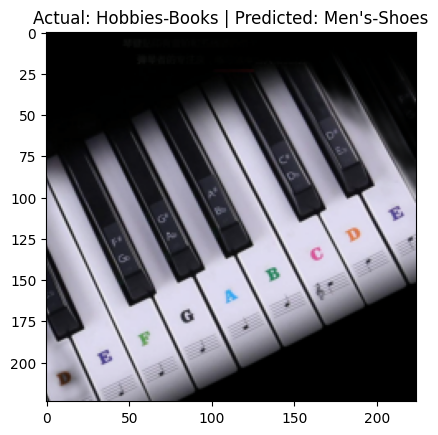

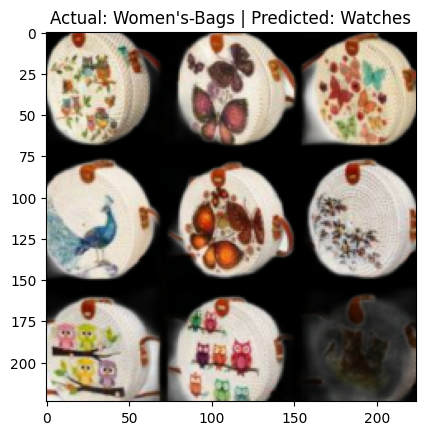

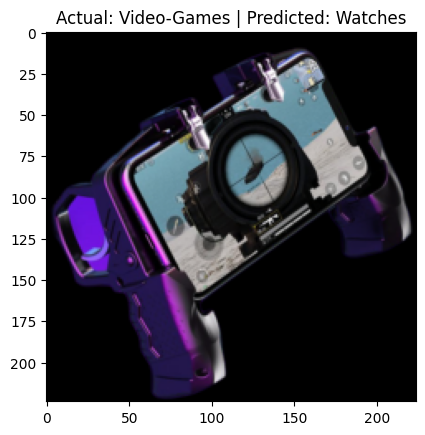

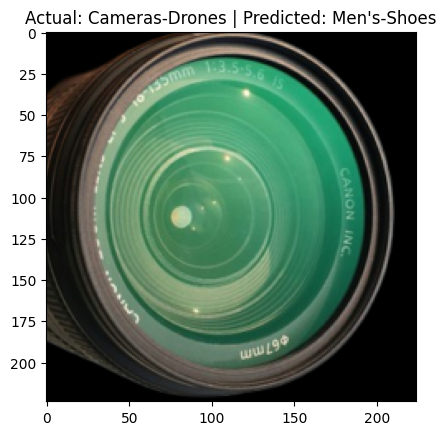

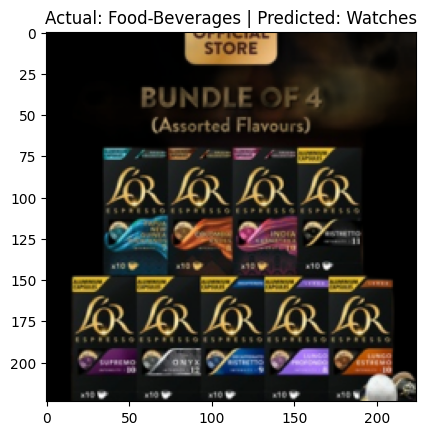

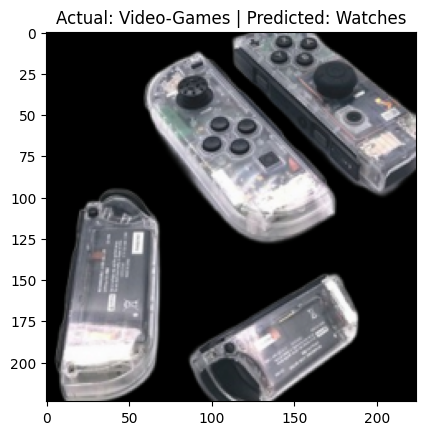

In [11]:
top_loss_images = mtrainer.images_with_max_loss(mtrainer.testloader, k=6)

from model.dataset import display_preprocessed_image

for img in top_loss_images:
    title = f"Actual: {data.categories[img[1]]} | Predicted: {data.categories[img[2]]}"
    display_preprocessed_image(img[0], title)

### Code to run experiments

#### Code for baseline model experiments

In [28]:
from scripts.experiment_runner import HyperParameter, ExperimentRunner
from model import baseline_cnn_1

# hyperparameters = [HyperParameter(4e-4, transform=True), HyperParameter(4e-4, reg=1e-3,transform=True)]

hyperparameters = [
    HyperParameter(4e-4), HyperParameter(4e-4, 1e-4), HyperParameter(4e-4, 5e-4), HyperParameter(4e-4, 1e-3), HyperParameter(4e-4, 1e-2),
    HyperParameter(4e-4, transform=True), HyperParameter(4e-4, reg=1e-3,transform=True)
]


runner = ExperimentRunner(baseline_cnn_1.BaselineCNN1, hyperparameters)

runner.run(data, 30)

base_run1 = runner.results

runner.result_summary()

Running seed: 42, hyperparameters: lr=0.0004|reg=0|True
[Epoch   0]: Training loss: 1.763034 | Accuracy: 0.371746
[Epoch   0]: Validation loss: 2.191156 | Accuracy: 0.268889 | Within 3: 0.651111
[Epoch   1]: Training loss: 1.601486 | Accuracy: 0.435556
[Epoch   1]: Validation loss: 1.657501 | Accuracy: 0.406667 | Within 3: 0.746667
[Epoch   2]: Training loss: 1.491926 | Accuracy: 0.484127
[Epoch   2]: Validation loss: 1.849421 | Accuracy: 0.337778 | Within 3: 0.726667
[Epoch   3]: Training loss: 1.418246 | Accuracy: 0.515238
[Epoch   3]: Validation loss: 1.834177 | Accuracy: 0.306667 | Within 3: 0.682222
[Epoch   4]: Training loss: 1.383109 | Accuracy: 0.524127
[Epoch   4]: Validation loss: 1.573074 | Accuracy: 0.491111 | Within 3: 0.793333
[Epoch   5]: Training loss: 1.329438 | Accuracy: 0.544444
[Epoch   5]: Validation loss: 1.484730 | Accuracy: 0.504444 | Within 3: 0.784444
[Epoch   6]: Training loss: 1.288629 | Accuracy: 0.562540
[Epoch   6]: Validation loss: 2.273481 | Accuracy: 0

({'lr=0.0004|reg=0|True': {'best': 0.6593333333333333,
   'last': 0.6235555555555555},
  'lr=0.0004|reg=0.001|True': {'best': 0.6646666666666666,
   'last': 0.6675555555555556}},
 {'lr=0.0004|reg=0|True': {'best': 0.010922849535506205,
   'last': 0.03763633652682595},
  'lr=0.0004|reg=0.001|True': {'best': 0.00984823102496017,
   'last': 0.00614234442714899}})

#### Code for depth model experiments

In [ ]:
from scripts.experiment_runner import HyperParameter, ExperimentRunner
from model import deeper_cnn

hyperparameters = [HyperParameter(4e-4), HyperParameter(3e-4)]

runner = ExperimentRunner(deeper_cnn.DeeperCNN, hyperparameters)

runner.run(data, 30)

deep_run = runner.results

runner.result_summary()

In [ ]:
from scripts.experiment_runner import HyperParameter, ExperimentRunner
from model import deeper_cnn

hyperparameters = [HyperParameter(4e-4), HyperParameter(3e-4)]

runner = ExperimentRunner(deeper_cnn.DeeperCNNWide, hyperparameters)

runner.run(data, 30)

deep_wide_run = runner.results

runner.result_summary()

#### Code for residual model experiments

In [ ]:
from model import residual_cnn
from scripts.experiment_runner import ExperimentRunner, HyperParameter

hyperparameters = [HyperParameter(4e-4), HyperParameter(3e-4)]

runner = ExperimentRunner(residual_cnn.ResidualCNN, hyperparameters)

runner.run(data, 30)

residual_run = runner.results

runner.result_summary()

In [7]:
from scripts.experiment_runner import HyperParameter, ExperimentRunner
from model import residual_cnn

hyperparameters = [HyperParameter(4e-4), HyperParameter(3e-4)]

runner = ExperimentRunner(residual_cnn.DeeperResidualCNN, hyperparameters)

runner.run(data, 30)

deep_residual_run = runner.results

runner.result_summary()

Running seed: 42, hyperparameters: lr=0.0004|reg=0|False
[Epoch   0]: Training loss: 1.752140 | Accuracy: 0.386349
[Epoch   0]: Validation loss: 3.422407 | Accuracy: 0.231111 | Within 3: 0.580000
[Epoch   1]: Training loss: 1.455953 | Accuracy: 0.500635
[Epoch   1]: Validation loss: 1.699808 | Accuracy: 0.442222 | Within 3: 0.746667
[Epoch   2]: Training loss: 1.333283 | Accuracy: 0.535873
[Epoch   2]: Validation loss: 1.727952 | Accuracy: 0.397778 | Within 3: 0.740000
[Epoch   3]: Training loss: 1.226903 | Accuracy: 0.579365
[Epoch   3]: Validation loss: 1.437970 | Accuracy: 0.546667 | Within 3: 0.804444
[Epoch   4]: Training loss: 1.114649 | Accuracy: 0.615556
[Epoch   4]: Validation loss: 1.357870 | Accuracy: 0.522222 | Within 3: 0.835556
[Epoch   5]: Training loss: 1.017618 | Accuracy: 0.656190
[Epoch   5]: Validation loss: 1.410370 | Accuracy: 0.528889 | Within 3: 0.835556
[Epoch   6]: Training loss: 0.951980 | Accuracy: 0.672381
[Epoch   6]: Validation loss: 1.179439 | Accuracy: 

({'lr=0.0004|reg=0|False': {'best': 0.6971111111111112,
   'last': 0.6931111111111111},
  'lr=0.0003|reg=0|False': {'best': 0.7024444444444444,
   'last': 0.6902222222222222}},
 {'lr=0.0004|reg=0|False': {'best': 0.01770261890369282,
   'last': 0.020910154659907088},
  'lr=0.0003|reg=0|False': {'best': 0.008055363982396398,
   'last': 0.014218749576041256}})